In [14]:
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import torch.optim as optim

In [15]:
def f_analytical(states, t = 0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    """
    ... states.shape = [num_states, 4] ...
    
    The analytical dynamics of the system in matrix form
    d/dt(theta1, theta2, omega1, omega2)
    """
    theta_1, theta_2, w_1, w_2 = states.T
    
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(theta_1 - theta_2)
    a2 = (l1 / l2) * np.cos(theta_1 - theta_2)
    
    
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w_2**2) * np.sin(theta_1 - theta_2) - \
        (g / l1) * np.sin(theta_1)
    f2 = (l1 / l2) * (w_1**2) * np.sin(theta_1 - theta_2) - (g / l2) * np.sin(theta_2)
    g_1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g_2 = (f2 - a2 * f1) / (1 - a1 * a2)
    
    return np.array([w_1, w_2, g_1, g_2]).T


def rk4_step(f, x, t, tau):
    """
    One step of runge-kutta integration
    """
    k1 = tau * f(x, tau)
    k2 = tau * f(x + k1/2, t + tau/2)
    k3 = tau * f(x + k2/2, t + tau/2)
    k4 = tau * f(x + k3, t + tau)
    
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)


def rk4_step_rectified(f, x, t, tau):
    
    k1 = tau * f(x)
    k2 = tau * f(x + k1/2)
    k3 = tau * f(x + k2/2)
    k4 = tau * f(x + k3)
    
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)


def solve_numerical(f, initial_state, t_arr, tau, solver = rk4_step):
    states = []
    
    for t in t_arr:
        states.append(initial_state)
        next_state = solver(f, initial_state, t, tau)
        initial_state = next_state
    
    return np.array(states)

In [61]:
def radial2cartesian(theta_1, theta_2, l1, l2):
    # Convert from radial to Cartesian coordinates.
    x1 = l1 * np.sin(theta_1)
    y1 = -l1 * np.cos(theta_1)
    x2 = x1 + l2 * np.sin(theta_2)
    y2 = y1 - l2 * np.cos(theta_2)
    return x1, y1, x2, y2


def plot_predicted_trajectory(cart_coords, model_name, save = False, verbose = True):
    x1, y1, x2, y2 = cart_coords
    
    length = len(x2)
    t = np.arange(length)
    
    plt.title(model_name)

    plt.plot(x2, y2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x2, y2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    if save == True:
        plt.savefig(Path("figures", "predicted_trajectory_" + model_name + ".png"), dpi=150)
    if verbose == True:
        plt.show()

def get_dynamics_coords(states, model_name, save = False, verbose = True):
    L1, L2 = 1, 1
    theta1, theta2 = states[:, 0], states[:, 1]
    cart_coords = radial2cartesian(theta1, theta2, L1, L2)

    print('making plots')
    plot_predicted_trajectory(cart_coords, model_name=model_name, save = save, verbose = verbose)
    return cart_coords

In [31]:
def normalize_angles(states):
    return np.hstack(((states[:, :2] + np.pi) % (2*np.pi), states[:, 2:]))

def visualize_data(x_train, x_test, save = False, verbose = True):
    print('Preparing for visualization...')
    # preprocess
    train_vis = normalize_angles(x_train)
    test_vis = normalize_angles(x_test)

    vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1) / 2
    vel_color = lambda vangle: np.stack([np.zeros_like(vangle), vangle, 1-vangle]).T
    train_colors = vel_color(vel_angle(train_vis))
    test_colors = vel_color(vel_angle(test_vis))

    print('Making visualization...')
    # plot
    SCALE = 80
    WIDTH = 0.006
    plt.figure(figsize=[8,4], dpi=120)
    plt.subplot(1, 2, 1)
    plt.title("Train data") 
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

    plt.subplot(1, 2, 2)
    plt.title("Test data")
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

    plt.tight_layout()
    
    if save == True:
        plt.savefig(Path("figures", "train_test_data_vis.png"), dpi=200)
        plt.savefig(Path("figures", "train_test_data_vis.pdf"), dpi=200)
    
    if verbose == True:
        plt.show()

In [32]:
TIME_STEP = 0.01
RANDOM_STATE = 123
N = 1500
PATH = Path("dataset", "data")

n_trajectories = 10
s = 2

In [24]:
time_step = TIME_STEP

t = np.arange(0, time_step*N, time_step) 

print('Making train...')

np.random.seed(seed = RANDOM_STATE)

initial_angles = np.random.uniform(0, 1, (n_trajectories, 2))*np.pi

initial_states = np.array([[angle_1, angle_2, 0, 0] for (angle_1, angle_2) in initial_angles])

trajectories = np.array([solve_numerical(f_analytical, initial_state, t, time_step) for initial_state in initial_states])

x_train = trajectories[:, :(4*N // 5), :].reshape(-1, 2*s)
x_test = trajectories[:, (4*N // 5):, :].reshape(-1, 2*s)

y_train = f_analytical(x_train)

y_test = f_analytical(x_test)

path_to_save = PATH

with open(Path(path_to_save, "train_data_new.pickle"), 'wb') as handle:
    pickle.dump([x_train, y_train], handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open(Path(path_to_save, "test_data_new.pickle"), 'wb') as handle:
    pickle.dump([x_test, y_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

Making train...


making plots


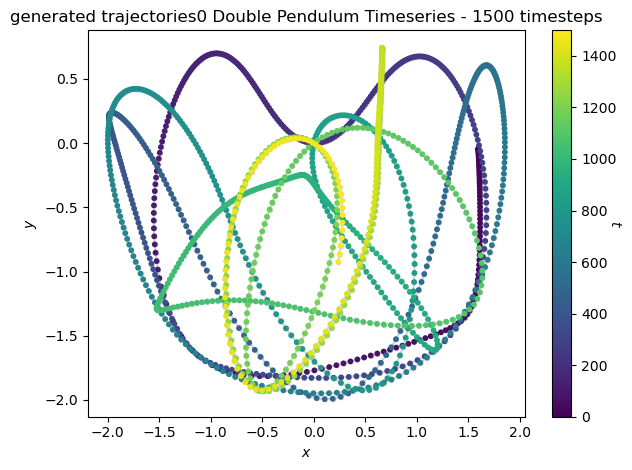

making plots


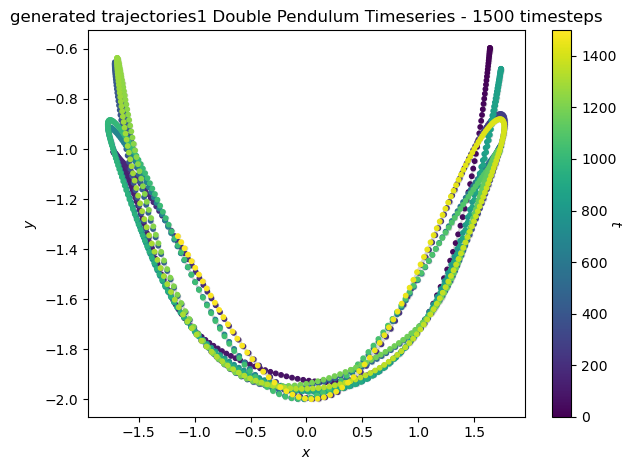

making plots


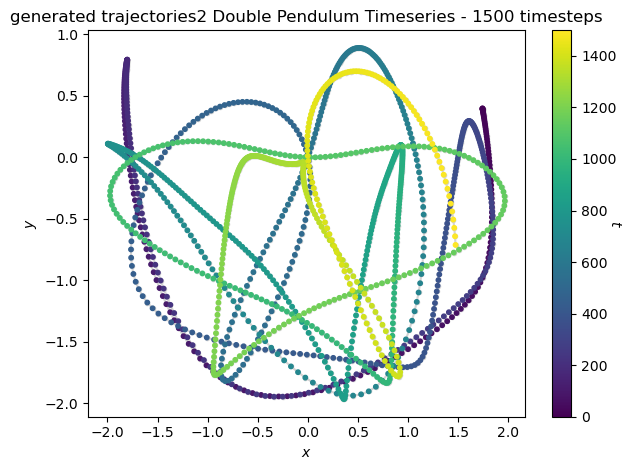

making plots


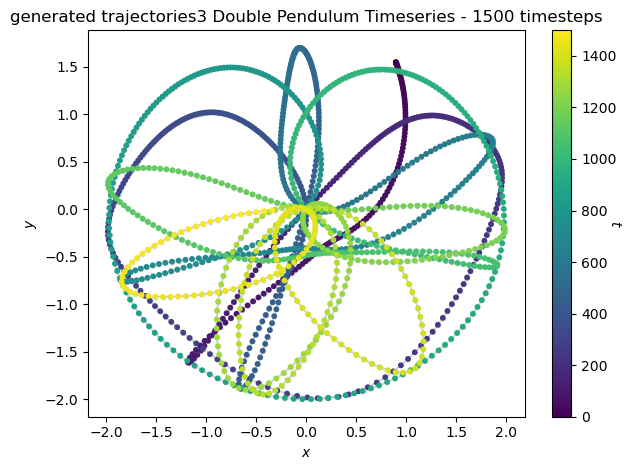

making plots


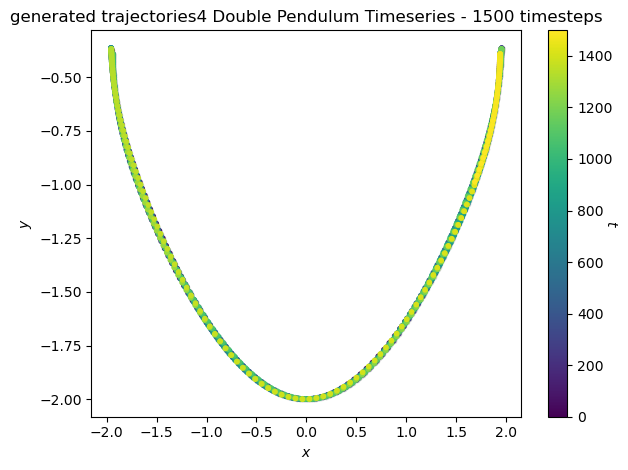

making plots


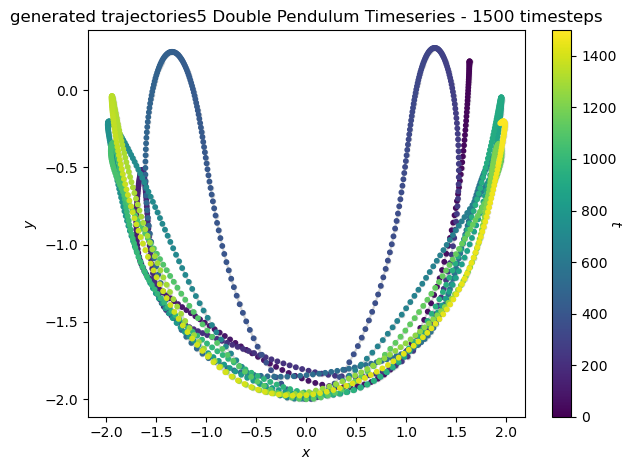

making plots


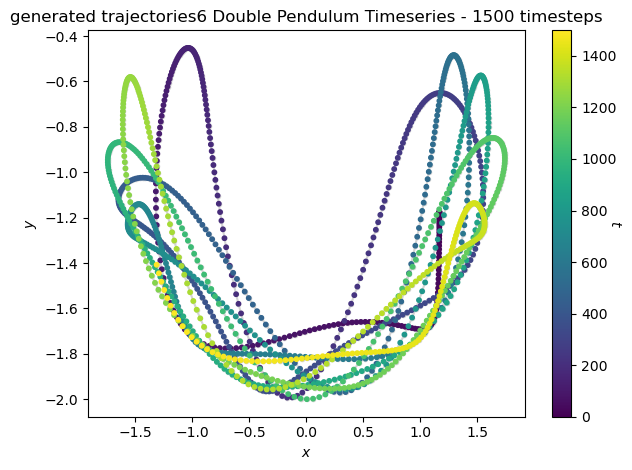

making plots


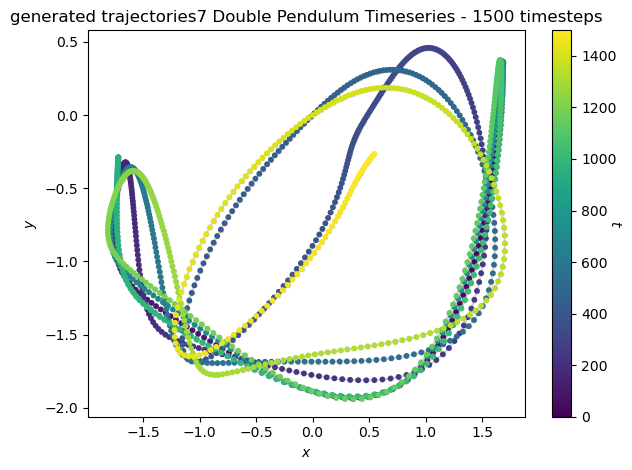

making plots


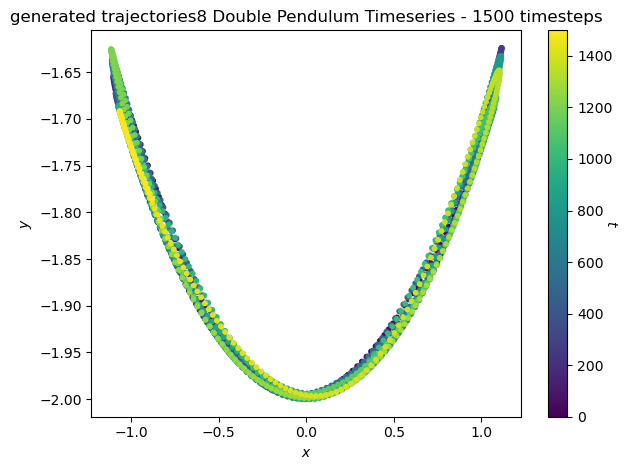

making plots


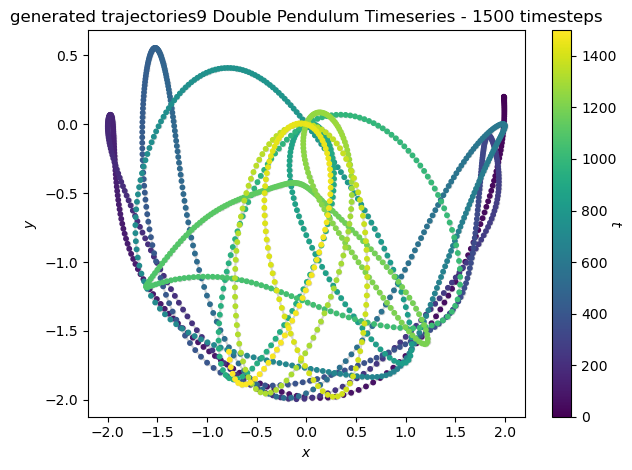

In [34]:
for i in range(10):
    _ = get_dynamics_coords(trajectories[i], 'generated trajectories' + str(i), save=True)
    plt.show()

making plots


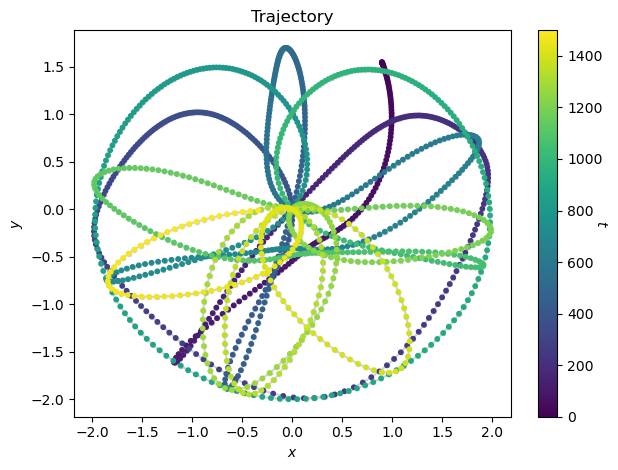

(array([ 0.06039428,  0.06028137,  0.0599432 , ..., -0.19219701,
        -0.165192  , -0.13833975]),
 array([ 0.9981746 ,  0.99818142,  0.99820179, ..., -0.98135636,
        -0.98626143, -0.99038483]),
 array([ 0.89649519,  0.89664405,  0.89708991, ..., -0.49660448,
        -0.418447  , -0.34001624]),
 array([ 1.54675027,  1.54635793,  1.54518021, ..., -0.02881445,
        -0.01886187, -0.01093264]))

In [63]:
get_dynamics_coords(trajectories[3], "Trajectory", save=True)

In [62]:
class DoublePendulumDataset(Dataset):
    def __init__(self, x_set, y_set):
        self.sample_list = list(zip(x_set, y_set))
        
    def __len__(self):
        return len(self.sample_list)
    
    def transform(state):
        angles = state[:2]
        return np.hstack(((angles + np.pi) % (2*np.pi) - np.pi, state[2:]))

    def __getitem__(self, idx):
        x_sample, y_sample = self.sample_list[idx]
        x_sample = DoublePendulumDataset.transform(x_sample)
        y_sample = DoublePendulumDataset.transform(y_sample)
        return x_sample.astype('float32'), y_sample.astype('float32')


with open(Path(PATH, "train_data_new.pickle"), 'rb') as f:
    train_data = pickle.load(f)
with open(Path(PATH, "test_data_new.pickle"), 'rb') as f:
    test_data = pickle.load(f)
    
[x_train, y_train] = train_data
[x_test, y_test] = test_data
    
train_dataset = DoublePendulumDataset(x_train, y_train)
test_dataset = DoublePendulumDataset(x_test, y_test)

In [37]:
class BaselineNN(nn.Module):
    def __init__(self, s = 2):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(2*s, 128),
            nn.Softplus(),
            nn.Linear(128, 128),
            nn.Softplus(),
            nn.Linear(128, 1),
        )

        
    def forward(self, x):
        return self.sequence(x)

In [38]:
def train_epoch(model, train_loader, optimizer, verbose = True):
    
    model.train()
    
    loss_func = nn.MSELoss()
    
    total_loss = 0
    
    for batch in tqdm(train_loader, disable = not verbose):
        coords, targets = batch # targets.shape = [batch_size, 4]
        
        preds = torch.zeros((len(targets), 2*s)) # preds.shape = [batch_size, 4]
        
        for i, (coord, target) in enumerate(list(zip(coords, targets))):
            
            J = jacobian(model, coord, create_graph = True, strict = True)[0]
            H = hessian(model, coord, create_graph = True, strict = True)
            
            H_qt_qt = H[s:, s:]

            H_qt_q = H[:s, s:]

            J_q = J[:s]

            q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ coord[s:])

            preds[i] = torch.cat((coord[s:], q_tt))
            
        loss = loss_func(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
    
    return total_loss/len(train_loader)


def test_epoch(model, test_loader, verbose = True):
    
    model.eval()
    
    loss_func = nn.MSELoss()
    
    total_loss = 0
    
    
    for batch in tqdm(test_loader, disable = not verbose):
        coords, targets = batch # targets.shape = [batch_size, 4]

        preds = torch.zeros((len(targets), 2*s)) # preds.shape = [batch_size, 4]

        for i, (coord, target) in enumerate(list(zip(coords, targets))):

            J = jacobian(model, coord)[0]
            H = hessian(model, coord)

            H_qt_qt = H[s:, s:]

            H_qt_q = H[:s, s:]

            J_q = J[:s]

            q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ coord[s:])

            preds[i] = torch.cat((coord[s:], q_tt))

        loss = loss_func(preds, targets)

        total_loss += loss

    return total_loss/len(test_loader)



def train_model(model, train_loader, test_loader, num_epochs, lr, verbose = True):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, verbose = verbose)
        test_loss = test_epoch(model, test_loader, verbose = verbose)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if verbose == True:
            print('============= Epoch {} =================='.format(epoch + 1))
            print('train loss: {}'.format(train_loss))
            print('test loss: {}'.format(test_loss))

    return train_losses, test_losses    

In [39]:
BATCH_SIZE = 32
LR = 1e-3
NUM_EPOCHS = 3

In [40]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [41]:
lnn_model = BaselineNN()

In [42]:
train_losses, test_losses = train_model(lnn_model, train_loader, test_loader, NUM_EPOCHS, LR)

100%|███████████████████████████████████████████| 94/94 [00:05<00:00, 17.25it/s]


============= Epoch 1 ==================
train loss: 281.7101135253906
test loss: 158.8394012451172


100%|███████████████████████████████████████████| 94/94 [00:05<00:00, 15.76it/s]


============= Epoch 2 ==================
train loss: 110.58450317382812
test loss: 158.58506774902344


100%|███████████████████████████████████████████| 94/94 [00:05<00:00, 16.92it/s]

============= Epoch 3 ==================
train loss: 110.3595962524414
test loss: 158.203857421875


In [54]:
def f_lnn(state, model = lnn_model):
    
    state = DoublePendulumDataset.transform(state)
    state = torch.from_numpy(state.astype('float32'))
    
    J = jacobian(model, state)[0]
    H = hessian(model, state)

    H_qt_qt = H[s:, s:]

    H_qt_q = H[:s, s:]

    J_q = J[:s]

    q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ state[s:])

    return torch.cat((state[s:], q_tt)).numpy()



time_step = TIME_STEP

n = 100

t_arr = np.arange(0, time_step * n, time_step) 

initial_state = initial_states[4]

pred_trajectory = solve_numerical(f_lnn, initial_state, t_arr, time_step, solver = rk4_step_rectified)

In [56]:
pred_trajectory[:10]

array([[1.51089213, 1.23187351, 0.        , 0.        ],
       [1.510902  , 1.23203704, 0.00199655, 0.03271874],
       [1.51093253, 1.23252818, 0.00413293, 0.06552449],
       [1.51098514, 1.23334783, 0.00641586, 0.09842141],
       [1.51106135, 1.23449693, 0.00885218, 0.13141381],
       [1.51116272, 1.23597644, 0.0114489 , 0.1645062 ],
       [1.51129089, 1.2377874 , 0.01421315, 0.19770326],
       [1.51144757, 1.23993087, 0.0171522 , 0.23100989],
       [1.51163454, 1.24240798, 0.02027353, 0.26443116],
       [1.51185367, 1.24521989, 0.02358473, 0.29797236]])

In [57]:
trajectories[4][:10]

array([[ 1.51089213,  1.23187351,  0.        ,  0.        ],
       [ 1.51039576,  1.23188859, -0.0992785 ,  0.00302744],
       [ 1.50890635,  1.23193453, -0.19861926,  0.0061957 ],
       [ 1.50642297,  1.23201344, -0.29808314,  0.00964301],
       [ 1.50294408,  1.23212877, -0.3977281 ,  0.01350236],
       [ 1.49846762,  1.23228528, -0.49760768,  0.0178987 ],
       [ 1.49299099,  1.23248891, -0.59776931,  0.02294591],
       [ 1.48651116,  1.2327467 , -0.69825244,  0.02874347],
       [ 1.47902477,  1.23306656, -0.79908645,  0.03537276],
       [ 1.4705282 ,  1.23345713, -0.90028834,  0.04289301]])

making plots


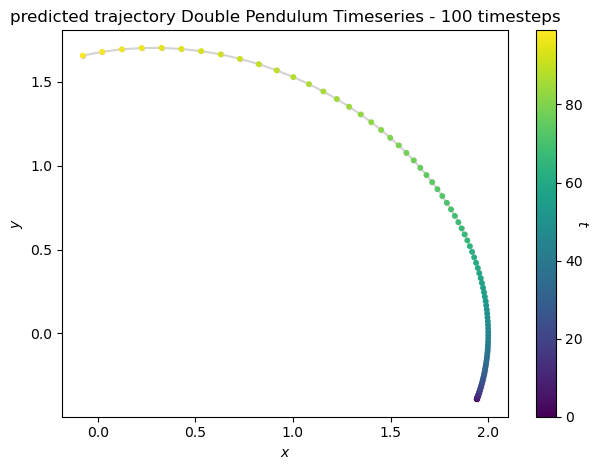

In [58]:
_ = get_dynamics_coords(pred_trajectory, 'predicted trajectory')

making plots


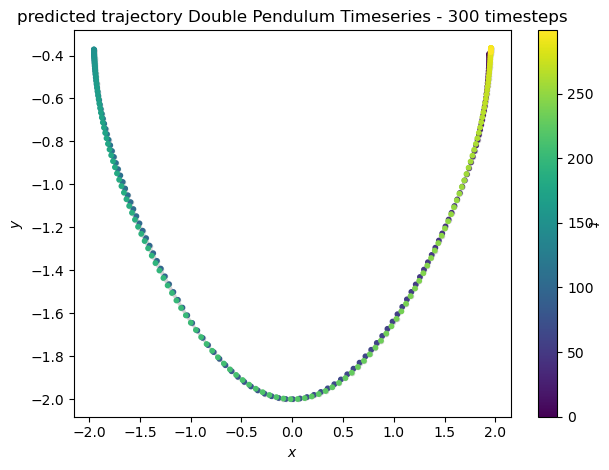

In [59]:
_ = get_dynamics_coords(trajectories[4][:300], 'predicted trajectory')

In [ ]:
pred_trajectory[4].shape